In [1]:
import numpy as np
import os
from skimage.io import imread
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

In [2]:
#log_params = {"A": 11.790409566163314, "mu_m": 0.02348393661706508, "lambda": 2.1454099415518964e-15}
log_params = {"A": 11.813539214813655, "mu_m": 0.02001919118343915, "lambda": -73.01216063634942}
incubation_time = 5.5 * 60 * 60 # 316/60 * 60 * 60
def logistic_growth_rate(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    gr = 4 * mu_m * np.exp(4 * mu_m / A * (l - t) + 2) / (1 + np.exp(4 * mu_m / A * (l - t) + 2))**2
    return gr / 60

def logistic(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    log_B = A / (1 + np.exp(4 * mu_m / A * (l - t) + 2))
    return np.exp(log_B)

In [3]:
path_ext = '/Users/timrudge/Pictures/Analyzed files' # '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}

exp_date = '2023_12_06'
#vector = 'pAAA'
#vector = 'pLPT107&pLPT41'
vector = 'pLPT20&pLPT41'
#vector = 'pLPT119&pLPT41'

#scope_name = 'Ti scope'
scope_name = 'Tweez scope'
pos = 14

if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_12_06_10x_1.0x_pLPT20&41_TiTweez_Pos14.ome.tif'

In [4]:
tf = 316
edt = np.load(os.path.join(path_results,'edt.npy'))[:tf,:,:]
nt,nx,ny = edt.shape
print(edt.shape)

(216, 1024, 1024)


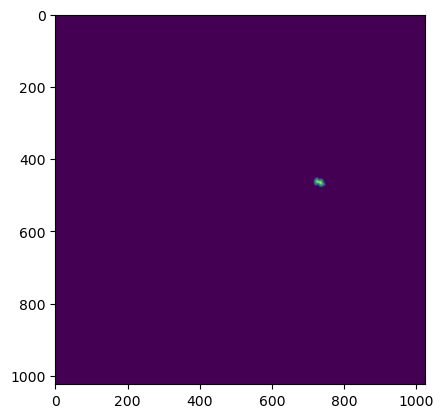

In [5]:
plt.imshow(edt[0,:,:])

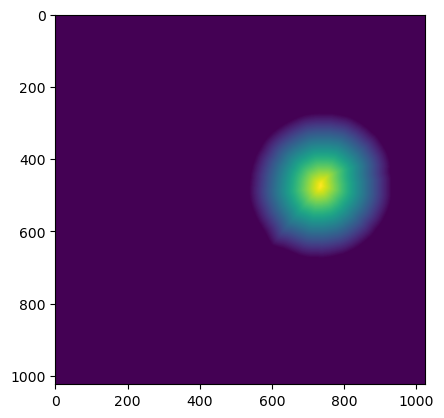

In [6]:
plt.imshow(edt[-1,:,:])

In [7]:
im = imread(os.path.join(path,fname))
print(im.shape)
im = im[:,:,:,[2,3,1]]
im = im[:tf,:,:,:ph_chn].astype(float)
print(im.shape)

<tifffile.TiffFile '2023_12_06_10x_…ez_Pos14.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile '2023_12_06_10x_…ez_Pos14.ome.tif'> MMStack series is missing files. Returning subset (1, 216, 4, 1) of (27, 216, 4, 1)


(216, 1024, 1024, 4)
(216, 1024, 1024, 2)


In [8]:
edt = np.pad(edt, ((0,0),(256,256),(256,256)))
im = np.pad(im, ((0,0),(256,256),(256,256),(0,0)))
nt,nx,ny = edt.shape

In [9]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 256

crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
crop_im = np.zeros((nt,w+2*pad,h+2*pad,2))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    tim = im[t,:,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    
    xl, xu = cx - w//2 - pad, cx + w//2 + pad
    yl, yu = cy - h//2 - pad, cy + h//2 + pad
    if xl < 0:
        xu = xu + np.abs(xl)
        xl = 0
    #print(f"xlow: {xl}, xhigh: {xu}")
    #print(f"ylow: {yl}, xhigh: {yu}")
    
    crop_edt[t,:,:] = tedt[xl:xu, yl:yu]
    crop_im[t,:,:] = tim[xl:xu, yl:yu,:]

400 392
(216, 912, 904)


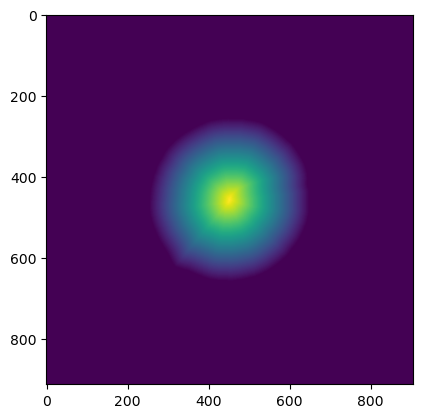

In [10]:
plt.imshow(crop_edt[-1,:,:])

#### Diffusion

In [11]:
nt,nx,ny = crop_edt.shape
offset = incubation_time / 60 / 10
ntt = nt + int(offset)
crop_edt = np.zeros((ntt,nx,ny))
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
cx,cy = nx/2, ny/2
R = np.sqrt((x-cx)**2 + (y-cy)**2)
area_all = np.zeros(ntt)
for t in range(ntt):
    area = logistic(t * 10 * 60 - offset * 10 * 60, log_params)
    area_all[t] = area
    radius = np.sqrt(area / np.pi)
    crop_edt[t,:,:] = radius - R
    tedt = crop_edt[t,:,:]
    tedt[tedt<0] = 0 
    crop_edt[t,:,:] = tedt
np.save(os.path.join(path_results,'diff_area_all.npy'),area_all)

In [12]:
def split_image_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width, channels = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size, channels))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for c in range(channels):
                for t in range(nt):
                    blocks[t, i, j, :, :, c] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size, c]
    return blocks

def split_edt_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for t in range(nt):
                blocks[t, i, j, :, :] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
    return blocks

In [13]:
edt_blocks = split_edt_into_blocks(crop_edt, 16)
del crop_edt

In [14]:
im_blocks = split_image_into_blocks(crop_im, 16)
del crop_im

In [15]:
crop_edt_low = edt_blocks.mean(axis=(3,4))
crop_im_low = im_blocks.mean(axis=(3,4))
print(crop_im_low.shape)

(216, 57, 56, 2)


In [16]:
#from skimage.transform import downscale_local_mean

#print(crop_edt.shape)
#crop_edt_low = np.zeros((ntt,60,60))
#crop_im_low = np.zeros((nt,60,60,2))

#for t in range(ntt):
#    edt_low = downscale_local_mean(crop_edt[t,:,:], (16,16))
#    crop_edt_low[t,:,:] = edt_low

#for t in range(nt):
#    im_low = downscale_local_mean(crop_im[t,:,:], (16,16,1))
#    crop_im_low[t,:,:] = im_low

crop_edt = crop_edt_low
crop_im = crop_im_low
print(crop_edt.shape)
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape

crop_im[crop_edt[int(offset):,:,:]==0] = np.nan

(249, 57, 56)


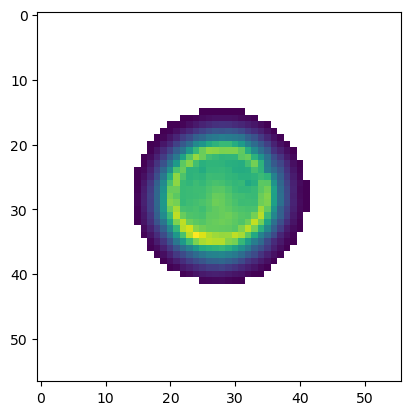

In [17]:
plt.imshow(crop_im[-120,:,:,1])

In [165]:
np.save(os.path.join(path_results, 'diff_crop_edt.npy'), crop_edt)
np.save(os.path.join(path_results, 'diff_crop_im.npy'), crop_im)

In [17]:
np.log(2) / (1e-5) / 60 / 60

19.254088348887368

In [18]:
u0 = np.zeros((nx,ny)) + 1
def dudt(u, t, tmask, phi, kappa, gamma, dx, t0):
    du = np.zeros((nx,ny))
    #du[tmask] += phi * 1 / (1 + np.exp((t - t0) / dt)) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='constant', cval=1)
    du += kappa * delu / dx / dx
    #du[tmask] -= gamma * u[tmask] * 1 / (1 + np.exp((t - t0) / dt))
    gr = logistic_growth_rate(t - offset * 10 * 60, log_params)
    du[tmask] -= gamma * u[tmask] * gr
    return du.ravel()

In [19]:
def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

#p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
#def dpdt(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, K, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp):
#    #G -| R -| B
#    p = p.reshape((nx,ny,4))
#    dpdt = np.zeros_like(p)
#    dpdt[:,:,0] = hill(uu, KK0, nn) / hill(1, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K)**n) - gamma_repr * p[:,:,0]
#    dpdt[:,:,1] = hill(uu, KK1, nn) / hill(1, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K)**n) - gamma_repr * p[:,:,1]
#    dpdt[:,:,2] = hill(uu, KK2, nn) / hill(1, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K)**n) - gamma_repr * p[:,:,2]
#    dpdt[:,:,3] = hill(uu, KK3, nn) / hill(1, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
#    #dpdt[:,:,3] = km0 * p[:,:,0] - gamma_fp * p[:,:,3]
#    #dpdt[:,:,4] = km1 * p[:,:,1] - gamma_fp * p[:,:,4]
#    #dpdt[:,:,5] = km2 * p[:,:,2] - gamma_fp * p[:,:,5]
#    for c in range(3):
#        cdpdt = dpdt[:,:,c]
#        cdpdt[tmask==0] = 0
#        dpdt[:,:,c] = cdpdt
#    return dpdt.ravel()

def shill(x, K, n):
    return 0.5 + n * (x - K) / 4 / K - n * (x - K)**2 / 8 / K / K

def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

def nhill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx) * (1 + K**n)

def step(x, K):
    return (x > K) * 1

def hill2(x, rep, Ku, Krep, nu, nrep):
    return (x/Ku)**nu / (1 + (x/Ku)**nu + (rep/Krep)**nrep)
    
p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
def dpdt(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, alpha5, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1):
    #G -| R -| B
    p = p.reshape((nx,ny,5))
    dpdt = np.zeros_like(p)
    # LacI
    #dpdt[:,:,0] = step(uu, KK0) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    #dpdt[:,:,0] = nhill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    dpdt[:,:,0] = alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    #dpdt[:,:,0] = hill2(uu, p[:,:,2], KK0, K2, nn, n) * alpha1 - gamma_repr * p[:,:,0]
    # TetR
    #dpdt[:,:,1] = step(uu, KK1) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    #dpdt[:,:,1] = nhill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    dpdt[:,:,1] = alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    #dpdt[:,:,1] = hill2(uu, p[:,:,0], KK1, K0, nn, n) * alpha2 - gamma_repr * p[:,:,1]
    # cI
    #dpdt[:,:,2] = step(uu, KK2) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = nhill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    dpdt[:,:,2] = alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = hill2(uu, p[:,:,1], KK2, K1, nn, n) * alpha3 - gamma_repr * p[:,:,2]
    # mVenus
    #dpdt[:,:,2] = step(uu, KK2) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = nhill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    dpdt[:,:,3] = alpha4 / (1 + (p[:,:,1]/K1)**n) - gamma_fp0 * p[:,:,3]
    #dpdt[:,:,2] = hill2(uu, p[:,:,1], KK2, K1, nn, n) * alpha3 - gamma_repr * p[:,:,2]
    # mCFP
    #dpdt[:,:,3] = step(uu, KK3) * alpha4 - gamma_repr * p[:,:,3]
    #dpdt[:,:,3] = nhill(uu, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
    dpdt[:,:,4] = alpha5 - gamma_fp1 * p[:,:,4]
    
    #dpdt[:,:,3] = km0 * p[:,:,0] - gamma_fp * p[:,:,3]
    #dpdt[:,:,4] = km1 * p[:,:,1] - gamma_fp * p[:,:,4]
    #dpdt[:,:,5] = km2 * p[:,:,2] - gamma_fp * p[:,:,5]
    for c in range(5):
        cdpdt = dpdt[:,:,c]
        cdpdt[tmask==0] = 0
        dpdt[:,:,c] = cdpdt
    return dpdt.ravel()



In [20]:
from scipy.integrate import odeint
def solve_gene_expression(rep00, rep01, rep02, u, alpha0, alpha1, alpha2, alpha3, alpha4, beta0, beta1, beta2, beta3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1, h, ts):
    nt = len(ts)
    print(nt)
    t0 = int(ts[0] * dt)
    p0 = crop_im[int(t0 / 60 / 10),:,:,:]
    p = np.zeros((nt+1,nx,ny,5))
    p[0,:,:,0] = rep00
    p[0,:,:,1] = rep01
    p[0,:,:,2] = rep02
    p[0,:,:,3] = p0[:,:,0]    
    p[0,:,:,4] = p0[:,:,1]
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[int(t0 / 60 / 10 + offset),:,:]>0 # crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10 + offset),:,:] # crop_edt[0,:,:]
        phi0 = alpha0 #* hill(u[ti,:,:], KK0, nn) + beta0
        phi1 = alpha1 #* hill(u[ti,:,:], KK1, nn) + beta1
        phi2 = alpha2 #* hill(u[ti,:,:], KK2, nn) + beta2
        phi3 = alpha3 * (hill(u[ti,:,:], KK2, nn) + beta2)
        phi4 = alpha4 * hill(u[ti,:,:], KK3, nn) + beta3
        dp = dpdt(p[ti,:,:,:], t, tmask>0, u[ti,:,:], phi0, phi1, phi2, phi3 * h, phi4 * h, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1)
        p[ti+1,:,:,:] = p[ti,:,:,:] + dt * dp.reshape(nx,ny,5)
        mask[ti+1,:,:] = tmask
    
    #p[:-1,:,:,0] = hill(u, KK0, nn) * p[:-1,:,:,0]
    #p[:-1,:,:,1] = hill(u, KK1, nn) * p[:-1,:,:,1]
    #p[:-1,:,:,2] = hill(u, KK2, nn) * p[:-1,:,:,2]
    #p[:-1,:,:,3] = hill(u, KK2, nn) * p[:-1,:,:,3]
    pmask = np.zeros_like(p) + np.nan
    for c in range(5):
        cp = p[:,:,:,c]
        cpmask = pmask[:,:,:,c]
        cpmask[mask>0] = cp[mask>0]
        pmask[:,:,:,c] = cpmask
    return pmask

def solve_diffusion(kappa, gamma, dx, dt, t0, ts):
    nt = len(ts)
    print(nt)
    u = np.zeros((nt+1,nx,ny))
    u[0,:,:] = u0
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10),:,:] # crop_edt[0,:,:]
        du = dudt(u[ti,:,:], t, tmask>0, 0, kappa, gamma, dx, t0)
        u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
        mask[ti+1,:,:] = tmask

    umask = np.zeros_like(u) + np.nan
    umask[mask>0] = u[mask>0]
    return umask

In [21]:
from scipy.signal import savgol_filter

def compute_dlog(x, w=21):
    return savgol_filter(np.log(x), w, 3, deriv=1, axis=0)

def compute_rho(x, y, w=21):
    rho_01 = x / y # pmask[:,:,:,0] / pmask[:,:,:,1]
    #rho_02 = pmask[:,:,:,0] / pmask[:,:,:,2]
    #rho_12 = pmask[:,:,:,1] / pmask[:,:,:,2]

    lrho_01 = np.log(rho_01)
    dslrho_01 = savgol_filter(lrho_01, w, 3, deriv=1, axis=0)
    #lrho_02 = np.log(rho_02)
    #dslrho_02 = savgol_filter(lrho_02, w, 3, deriv=1, axis=0)
    #lrho_12 = np.log(rho_12)
    #dslrho_12 = savgol_filter(lrho_12, w, 3, deriv=1, axis=0)

    #return rho_01,rho_02,rho_12, dslrho_01,dslrho_02,dslrho_12
    return rho_01,dslrho_01

In [22]:
from scipy.interpolate import interp1d

def residuals(x):
    print(np.exp(x))
    ha, K0, rep00, rep01, rep02 = np.exp(x)
    ts = np.arange(0, np.floor(32 * 60 * 60 // dt + offset * 10 * 60 / dt))
    umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
    uu = umask[:-1,:,:]
    ts2 = np.arange(np.floor(12 * 60 * 60 // dt), np.floor(32 * 60 * 60 // dt))
    u = uu[ts >= 12 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
    tidx0 = int(12 * 60 * 60 // dt // 60)
    tidx1 = int(32 * 60 * 60 // dt // 60)
    r = crop_edt[tidx0+int(offset),:,:]
    rr = r / crop_edt.max()
    #x0,x1,C = ha,1,-hb
    #h = C * rr * rr * rr + (-2 * C + x0 - x1) * rr * rr + (C - 2 * (x0 - x1)) * rr + x0
    sigma = ha
    h = np.exp(-(rr-1)**2/sigma)
    h = (h - h.min()) / (h.max() - h.min())
    h[r<0] = 0
    print(f'max(h),min(h) = {np.nanmin(h), np.nanmax(h)}')
    pmask = solve_gene_expression(rep00, rep01, rep02, u, 1, 1, 1, alpha0, alpha1, beta0, beta1, beta2, beta3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1, h, ts2)

    p = pmask[:-1:60,:,:,3:]
    
    print(p.shape)
    cx = int(nx//2)
    cy = int(ny//2)
    #model = p[20:,:,:,:] # [:,cx-4:cx+4,cy-4:cy+4,:] # [:,int(nx//2),int(ny//2)-4,:]
    model = p
    print(f'Min model = {np.nanmin(model)}')
    #data = crop_im[tidx0+20:tidx1,:,:,:2] # cx-4:cx+4,cy-4:cy+4,:2]
    data = crop_im[tidx0:tidx1,:,:,:2] # cx-4:cx+4,cy-4:cy+4,:2]
    print(f'Min data = {np.nanmin(data)}')
    resid_data = (model - data) # / data
    resid_data[:,:,:,0] = resid_data[:,:,:,0] / np.nanmean(data[:,:,:,0])
    resid_data[:,:,:,1] = resid_data[:,:,:,1] / np.nanmean(data[:,:,:,1])
    resid = resid_data
    idx = np.isfinite(resid)
    resid = resid[idx]
    mse = np.mean(resid*resid)
    print(f'mse = {mse}')
    return resid
    #return mse

In [23]:
from scipy.optimize import least_squares, fmin, minimize

rep00,rep01,rep02 = 5,1e-3,1e-3
alpha0,alpha1,alpha2,alpha3 = 1,1,1,1
alpha = 1
beta0,beta1,beta2,beta3 = 1e-3,1e-3,1e-3,1e-3
K0,K1,K2 = 1,1,1
K = 1
KK0,KK1,KK2,KK3 = 1,1,1,1
n = 4
nn = 1
#kappa = 1e-14
gamma = 1
gamma_fp = np.log(2) / (12 * 60 * 60)
gamma_fp0 = gamma_fp
gamma_fp1 = gamma_fp
gamma_repr = np.log(2) / (10 * 60)
dx = 16e-6
dt = 10
t0 = 0

ha = 0.5

#ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
#umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
#uu = umask[:-1,:,:]

rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])  

#kappa, rep00, rep01, rep02,K,gamma_repr,KK0,KK1,KK2,KK3,nn = [1.90477568e-13, 2.40914790e-02, 1.23843785e+00, 3.67041049e+03, 2.42493865e+03, 2.92348718e-04, 4.55484789e-01, 3.22305581e-01, 2.66946556e-01, 2.84130169e-01, 6.74474278e+00]
#kappa,gamma,rep00, rep01, rep02,K,gamma_repr,KK0, KK1, KK2, KK3, nn = [1.46369824e-13, 5.41780938e+00, 2.41599534e+02, 1.02036301e+03, 4.45643474e+00, 1.71248412e+03, 3.20572744e-04, 2.29179548e-01, 3.54992148e-02, 4.78930529e-02, 4.24058609e-02, 9.59379329e+00]
ha, kappa, gamma_fp0, gamma_fp1, alpha0, alpha1, beta2, beta3, gamma, K0, K1, K2, gamma_repr, rep00, rep01, rep02, KK2, KK3, nn = np.load(f'xopt_pLPT20&pLPT41_2023_12_08_Tweez scope_pos12_testing_fp_only.npy')
#kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')
lb = [1e-6, 1e-6, 1e-8, 1e-8, 1e-8]
ub = [1e6, 1e6, 1e6, 1e6, 1e6]
bounds = np.log([lb,ub])
res = least_squares(residuals, np.log([ha, K0, rep00, rep01, rep02]), bounds=bounds, ftol=1e-3)

[6.74152339e-01 1.05381787e-06 9.66366250e+05 1.00084979e-06
 4.76089924e+02]
13500
max(h),min(h) = (0.0, 1.0)
7200
(120, 57, 56, 2)
Min model = 0.28848365377109475
Min data = 210.0078125
mse = 33.45812606406443
[6.74152329e-01 1.05381787e-06 9.66366250e+05 1.00084979e-06
 4.76089924e+02]
13500
max(h),min(h) = (0.0, 1.0)
7200
(120, 57, 56, 2)
Min model = 0.28848364982393465
Min data = 210.0078125
mse = 33.45812577975574
[6.74152339e-01 1.05381765e-06 9.66366250e+05 1.00084979e-06
 4.76089924e+02]
13500
max(h),min(h) = (0.0, 1.0)
7200
(120, 57, 56, 2)
Min model = 0.28848365377109475
Min data = 210.0078125
mse = 33.45812652732401
[6.74152339e-01 1.05381787e-06 9.66366448e+05 1.00084979e-06
 4.76089924e+02]
13500
max(h),min(h) = (0.0, 1.0)
7200
(120, 57, 56, 2)
Min model = 0.28848365377109475
Min data = 210.0078125
mse = 33.45812646456229
[6.74152339e-01 1.05381787e-06 9.66366250e+05 1.00084958e-06
 4.76089924e+02]
13500
max(h),min(h) = (0.0, 1.0)
7200
(120, 57, 56, 2)
Min model = 0.28848

In [38]:
np.save(os.path.join(path_results,'diff_umask.npy'),umask) # solution for dilution
np.save(os.path.join(path_results,'diff_uu.npy'),uu) # uu = umask[:-1,:,:]

In [39]:
print(np.exp(res.x))
print(np.log(2) / gamma_repr / 60)
print(res.grad)

[1.27859291e-13 8.67763536e+00 2.80095145e+03 2.18049801e+03
 2.65645301e+03 1.00138861e-06 2.17142074e-04 1.33284238e-01
 1.25310561e-03 1.56608821e-03 1.91132515e-06 2.01803272e+01]
51.89111730421959
[-6.31011327e-04  1.03398247e-03  8.34760182e-04 -5.94176732e-05
 -1.49445970e-04 -5.22644754e-13  5.38201677e-04  1.13201435e-03
  9.91937748e-05 -4.28463612e-05  0.00000000e+00 -4.10081563e-04]


In [130]:
np.save(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_testing_fp_only_iptg.npy', np.exp(res.x))

In [131]:
x = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_testing_fp_only_iptg.npy')
x

array([8.36227666e-01, 8.90273092e+00, 4.34769140e-07, 2.28983616e+02,
       4.06383172e-05])

In [132]:
np.exp(res.x)

array([8.36227666e-01, 8.90273092e+00, 4.34769140e-07, 2.28983616e+02,
       4.06383172e-05])

In [32]:
#alpha0, alpha1, alpha2, alpha3, kappa, gamma, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.exp(res.x)
#alpha0,alpha1,alpha2,alpha3,kappa,gamma,rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_alphas_no_Ks.npy')
ha, K0, rep00, rep01, rep02 = np.exp(res.x)
#kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_testing.npy')
#kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')#np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}.npy')

ts = np.arange(0, np.floor(32 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(12 * 60 * 60 // dt), np.floor(32 * 60 * 60 // dt))
u = uu[ts >= 12 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
tidx0 = int(12 * 60 * 60 // dt // 60)
tidx1 = int(32 * 60 * 60 // dt // 60)
r = crop_edt[tidx0+int(offset),:,:]
rr = r / crop_edt.max()
#x0,x1,C = ha,1,-hb
#h = C * rr * rr * rr + (-2 * C + x0 - x1) * rr * rr + (C - 2 * (x0 - x1)) * rr + x0
sigma = ha
h = np.exp(-(rr-1)**2/sigma)
h = (h - h.min()) / (h.max() - h.min())
h[r<0] = 0
print(f'max(h),min(h) = {np.nanmin(h), np.nanmax(h)}')

pmask = solve_gene_expression(rep00, rep01, rep02, u, 1, 1, 1, alpha0, alpha1, beta0, beta1, beta2, beta3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1, h, ts2)

print(np.nanmin(pmask))
print(pmask.shape)
p = pmask[:-1:60,:,:,:]
mrho,mdslrho = compute_rho(p[:,:,:,3], p[:,:,:,4], w=41)  
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1], w=41)

13500
max(h),min(h) = (0.0, 1.0)
7200
1.1748976187588377e-08
(7201, 57, 56, 5)


In [205]:
K

0.2506142829938354

Text(0, 0.5, 'Position (pixels)')

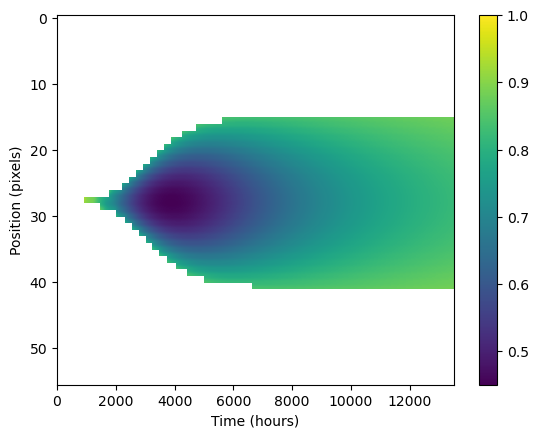

In [33]:
plt.imshow(umask[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()
#plt.contour(u[10:,int(nx//2),:].transpose(), [0.025])
plt.xlabel('Time (hours)')
plt.ylabel('Position (pixels)')

In [47]:
np.save(os.path.join(path_results,'diff_pmask.npy'),pmask) # solution for gene expression
np.save(os.path.join(path_results,'diff_p.npy'),p) # p = pmask[:-1:120,:,:,:]
np.save(os.path.join(path_results,'diff_umask.npy'),umask) # solution for dilution
np.save(os.path.join(path_results,'diff_uu.npy'),uu) # uu = umask[:-1,:,:]
np.save(os.path.join(path_results,'diff_mrho.npy'),mrho) # model
np.save(os.path.join(path_results,'diff_mdslrho.npy'),mdslrho) # model
np.save(os.path.join(path_results,'diff_rho_01.npy'),rho) # data
np.save(os.path.join(path_results,'diff_dslrho_01.npy'),dslrho) # data

In [26]:
print(f'ha = {ha}')
print(f'K = {K0,K1,K2}')
print(f'alpha0,alpha1 = {alpha0,alpha1}')
print(f'KK0 = {KK0}')
print(f'KK1 = {KK1}')
print(f'KK2 = {KK2}')
print(f'KK3 = {KK3}')
print(f'nn = {nn}')
print(f'kappa, gamma = {kappa,gamma}')
print(f'rep0 = {rep00, rep01, rep02}')
print(f'Repressor half life = {np.log(2) / gamma_repr / 60} mins')
print(f'FP0 half life = {np.log(2) / gamma_fp0 / 60 / 60} hrs')
print(f'FP1 half life = {np.log(2) / gamma_fp1 / 60 / 60} hrs')

ha = 0.6407959930127675
K = (0.38455026109176094, 169.68445362869718, 0.13350781598219452)
alpha0,alpha1 = (0.3263668455546034, 5.497651353932929)
KK0 = 1
KK1 = 1
KK2 = 0.6942366381245259
KK3 = 0.6779200360962558
nn = 58.57511315466787
kappa, gamma = (2.3206840863932476e-13, 0.544878835616011)
rep0 = (5.8041444952455514e-08, 427.19695502322014, 1.1748976187588377e-08)
Repressor half life = 20.771727121463055 mins
FP0 half life = 12.279618547857378 hrs
FP1 half life = 0.8277250145107887 hrs


In [8]:
gamma_repr

0.00021714207438540187

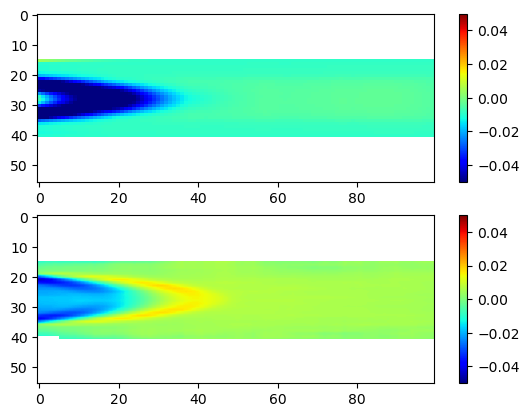

In [27]:
plt.subplot(2, 1, 1)
plt.imshow(mdslrho[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

idx0 = int(12 * 60 * 60 // dt // 60)
idx1 = int(32 * 60 * 60 // dt // 60)

plt.subplot(2, 1, 2)
plt.imshow(dslrho[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

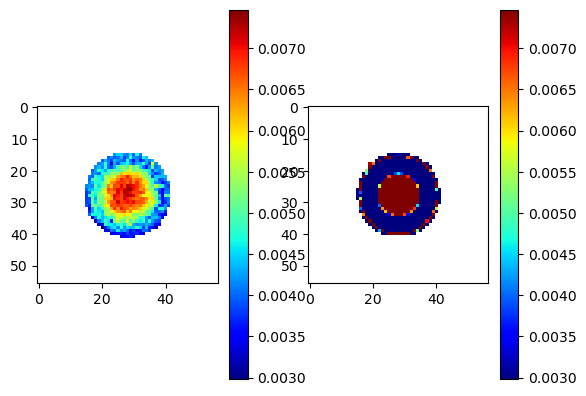

In [65]:
tpt = 50
vmin = np.nanmin(dslrho[idx1-tpt,:,:])
vmax = np.nanmax(dslrho[idx1-tpt,:,:])
plt.subplot(1, 2, 1)
plt.imshow(dslrho[idx1-tpt,:,:].transpose(), aspect='equal', cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(mdslrho[-tpt,:,:].transpose(), aspect='equal', cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

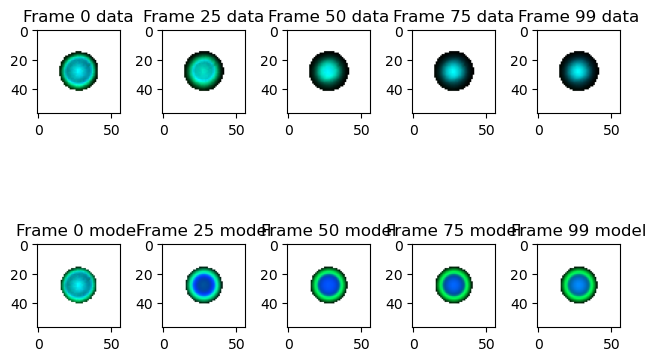

In [34]:
tidxs = [0, 25, 50, 75, 99]
ntidx = len(tidxs)
fig,axs = plt.subplots(2, ntidx)
for i in range(ntidx):
    tidx = tidxs[i]

    cim = np.zeros((nx,ny,3))
    cim1 = crop_im[idx0+tidx,:,:,0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = crop_im[idx0+tidx,:,:,1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,1] = cim1
    cim[:,:,2] = cim2
    cim[crop_edt[idx0+tidx+int(offset),:,:]==0] = 1
    axs[0,i].imshow(cim, aspect='equal')
    axs[0,i].set_title(f'Frame {tidx} data')

    cim = np.zeros((nx,ny,3))
    cim1 = p[tidx,:,:,3]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = p[tidx,:,:,4]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,1] = cim1
    cim[:,:,2] = cim2
    cim[crop_edt[idx0+tidx+int(offset),:,:]<8] = 1
    axs[1,i].imshow(cim, aspect='equal')
    axs[1,i].set_title(f'Frame {tidx} model')
plt.tight_layout()

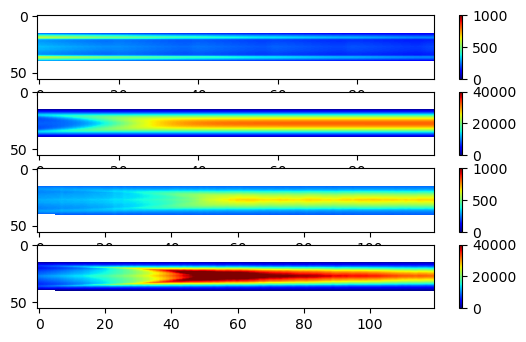

In [29]:
plt.subplot(5, 1, 1)
plt.imshow(p[:,int(nx//2),:,3].transpose(), aspect='auto', cmap='jet', vmin=0, vmax=1e3)
plt.colorbar()
plt.subplot(5, 1, 2)
plt.imshow(p[:,int(nx//2),:,4].transpose(), aspect='auto', cmap='jet', vmin=0, vmax=4e4)
plt.colorbar()
plt.subplot(5, 1, 3)
plt.imshow(crop_im[idx0:idx1,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet', vmin=0, vmax=1e3)
plt.colorbar()
plt.subplot(5, 1, 4)
plt.imshow(crop_im[idx0:idx1,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet', vmin=0, vmax=4e4)
plt.colorbar()

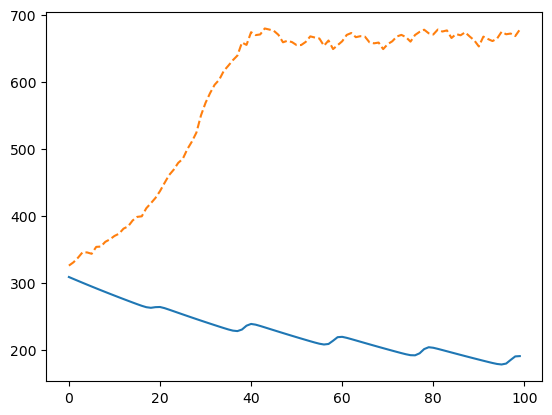

In [31]:
plt.plot((p[:,int(nx//2),int(ny//2),3])) #, aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.plot((crop_im[idx0+20:idx1,int(nx//2),int(ny//2),0]), '--') # , aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
#plt.colorbar()

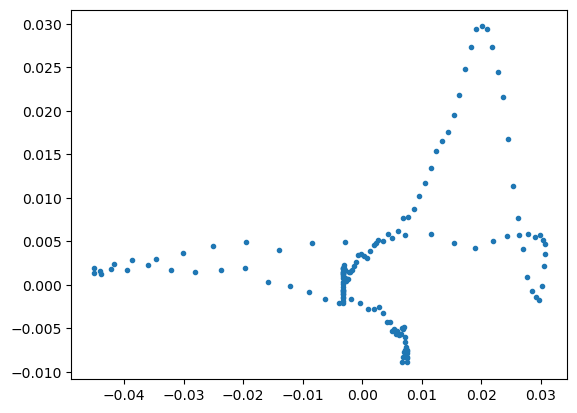

In [355]:
plt.plot(mdslrho[:,int(nx//2),int(ny//2)].ravel(), dslrho[idx0+20:idx1,int(nx//2),int(ny//2)].ravel(), '.')

In [95]:
x,y = mdslrho[:,int(nx//2),int(ny//2)].ravel(), dslrho[idx0+20:idx1,int(nx//2),int(ny//2)].ravel()
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
np.corrcoef(x, y)

array([[1.        , 0.85317256],
       [0.85317256, 1.        ]])

In [7]:
# Assuming the array is loaded from a .npy file as follows:
kappa, gamma, K, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}.npy')

# Print the parameter names along with their values
print(f"kappa: {kappa}")
print(f"gamma: {gamma}")
print(f"K: {K}")
print(f"rep00: {rep00}")
print(f"rep01: {rep01}")
print(f"rep02: {rep02}")
print(f"gamma_repr: {gamma_repr}")
print(f"KK0: {KK0}")
print(f"KK1: {KK1}")
print(f"KK2: {KK2}")
print(f"KK3: {KK3}")
print(f"nn: {nn}")


kappa: 1.2785929136671317e-13
gamma: 8.677635357269166
K: 2800.95145219157
rep00: 2180.4980068491413
rep01: 2656.453005306282
rep02: 1.0013886125172725e-06
gamma_repr: 0.00021714207438540187
KK0: 0.13328423828745725
KK1: 0.0012531056066526762
KK2: 0.001566088206995421
KK3: 1.911325145246321e-06
nn: 20.18032718405063
